#**Initial Implementation - Team Dash Trackers**
###Team members: Simran Kaur,  Sofia Luong, Xinchen Li, Abigail Chen
GitHub Repo: [Github - UCLA-Data-Sci-25](https://github.com/abigailyc/UCLA-Data-Sci-25)
---

1. We chose the [DoorDash ETA Prediction](https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction/data) dataset for our project.

2. Our response variable is *‘total_seconds.*’ We created this new column by subtracting the *‘created_at*’ feature from the *‘actual_delivery_time*’ feature. This represents the total time in seconds a DoorDash order takes from when it was ordered to when it was delivered. We are studying this to see what variables impact the time it takes for a delivery to be completed. At the moment, these are the main predictors we have chosen based on the greedy algorithm we coded:
	- ‘estimated_store_to_consumer_driving_duration’
	- ‘total_outstanding_orders’
	- ‘total_onshift_dashers’
	- ‘subtotal’
	- ‘hour_of_day’

	We are still researching which predictors will enhance our model further, if any.


3. a) The data cleaning and preprocessing we did consisted of dropping irrelavent featuress and dropping the rows with samples that had NaN values in them. We also did feature engineering by creating a new feature (our target variable) which calculates the total seconds it took for a delivery to be completed. We also introduced two new features: 'hour_of_day' and 'weekday' based on the 'created_at' feature. Finally, we removed outliers and normalized our data.

	b) We plotted the correlation matrix to see correlations between possible predictors and the target variable. We also implemented a forwards greedy algorithm to select the optimal features (unique to each model type) to use to predict the total_seconds feature. Finally, we plotted scatter plots to see relationships between predictors and response variables that may not have been evident through the other methods described above.

	c) We implemented a linear regression model to predict our response variable using training and testing datasets. We also tried using neural networks to predict our response variable.

	d) For classification, we used decision trees and logistic regression models. However, we realized that the logistic regression model is not appropriate because our response variable is not categorical.

4. GitHub Repo: [Github - UCLA-Data-Sci-25](https://github.com/abigailyc/UCLA-Data-Sci-25)

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

data = pd.read_csv('/content/historical_data.csv.zip')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


##**Data Cleaning, Pre-Processing, and EDA**

There are ‘created_at’ & ‘actual_delivery_time’ columns, but no column that represents the total time a delivery took. We need to introduce this response variable to represent the total delivery time in seconds.

We create a new column ‘total_seconds’ by subtracting ‘created_at’ from ‘actual_delivery_time’  to represent the response variable.

We also introduced new features ‘weekday’ & ‘hour_of_day’ by deriving them from the ‘created_at’ feature.

In [62]:
data_cleaned = data.copy()
created_at = pd.to_datetime(data_cleaned['created_at'])
actual_delivery_time = pd.to_datetime(data_cleaned['actual_delivery_time'])

data_cleaned['hour_of_day'] = created_at.dt.hour
data_cleaned['weekday'] = actual_delivery_time.dt.weekday

data_cleaned['total_seconds'] = (actual_delivery_time - created_at).dt.total_seconds()
data_cleaned = data_cleaned[data_cleaned['total_seconds']>0]

data_cleaned = data_cleaned.drop(["actual_delivery_time", "created_at"], axis=1)

Run the cell below to see which columns have missing values

In [63]:
data_cleaned.isnull().sum()

,0
market_id,987
store_id,0
store_primary_category,4760
order_protocol,995
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0
max_item_price,0
total_onshift_dashers,16262


Since 'total_outstanding_orders', 'total_busy_dashers', & 'total_onshift_dashers' have 16,262 missing values, we removed these rows with missing values.

For others with fewer missing values, impute missing values with the mean.

Finally, drop 'store_primary_category' because it is categorical data and has too many unique values to one-hot encode.

In [64]:
data_cleaned2 = data_cleaned.dropna(subset=['total_outstanding_orders','total_busy_dashers', 'order_protocol',
                                            'total_onshift_dashers','market_id'])

data_cleaned3 = data_cleaned2.drop(['store_id','store_primary_category'], axis=1)

data_cleaned3 = data_cleaned3.fillna(data_cleaned3.mean())

for column in data_cleaned3.columns:
  data_cleaned3 = data_cleaned3[(data_cleaned3 >= 0).all(axis=1)]

##**EDA Techniques - Correlation Matrix**

In [65]:
correlation_matrix = data_cleaned3.corr(numeric_only=True)
correlation_matrix

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour_of_day,weekday,total_seconds
market_id,1.000000,-0.015099,0.002252,-0.002150,0.013399,-0.009260,-0.005579,0.069618,0.060304,0.063577,-0.048449,0.017690,-0.008955,0.000246,-0.038260
order_protocol,-0.015099,1.000000,0.005461,-0.052517,-0.026382,-0.041516,-0.088571,0.145204,0.149720,0.135087,-0.684376,-0.010016,0.013644,0.000489,-0.047078
total_items,0.002252,0.005461,1.000000,0.557724,0.759858,-0.388862,-0.053767,0.031671,0.028544,0.034353,-0.023938,0.007434,-0.071021,0.020693,0.078816
subtotal,-0.002150,-0.052517,0.557724,1.000000,0.681470,0.039135,0.508397,0.130883,0.125626,0.130077,0.034431,0.038441,-0.190691,0.029300,0.144448
num_distinct_items,0.013399,-0.026382,0.759858,0.681470,1.000000,-0.445491,0.046538,0.065684,0.060403,0.067547,0.003159,0.025073,-0.119321,0.028235,0.106671
min_item_price,-0.009260,-0.041516,-0.388862,0.039135,-0.445491,1.000000,0.543115,0.042748,0.044237,0.041296,0.051695,0.004132,-0.051422,-0.002037,0.008588
max_item_price,-0.005579,-0.088571,-0.053767,0.508397,0.046538,0.543115,1.000000,0.133091,0.131005,0.130601,0.084059,0.028621,-0.189245,0.026098,0.088860
total_onshift_dashers,0.069618,0.145204,0.031671,0.130883,0.065684,0.042748,0.133091,1.000000,0.943778,0.936130,-0.185697,0.045936,-0.374118,0.102834,0.046993
total_busy_dashers,0.060304,0.149720,0.028544,0.125626,0.060403,0.044237,0.131005,0.943778,1.000000,0.932918,-0.191731,0.044436,-0.349582,0.084235,0.060603
total_outstanding_orders,0.063577,0.135087,0.034353,0.130077,0.067547,0.041296,0.130601,0.936130,0.932918,1.000000,-0.172367,0.039713,-0.361805,0.089639,0.122108


After analyzing the correlation matrix, we can see that following feature pairs have extremely high correlations with each other.

- 'num_distinct_items' vs. 'total_items'

- 'total_onshift_dashers' vs. 'total_busy_dashers'

- 'total_onshift_dashers' vs. 'total_outstanding_orders' and

- 'order_protocol' vs. 'estimated_order_place_duration'


We need to drop one of the two columns from each pair so that it doesn't negatively impact the results of our models.

We dropped the column with a lower correlation with the response variable of the two for each pair.

In [66]:
data_cleaned4 = data_cleaned3.drop(['num_distinct_items','total_onshift_dashers','total_busy_dashers','order_protocol'], axis=1)

##**EDA Techniques - Graphing Scatter Plots**

###market_id vs. total_seconds###


Text(0.5, 1.0, 'market_id vs. total seconds')

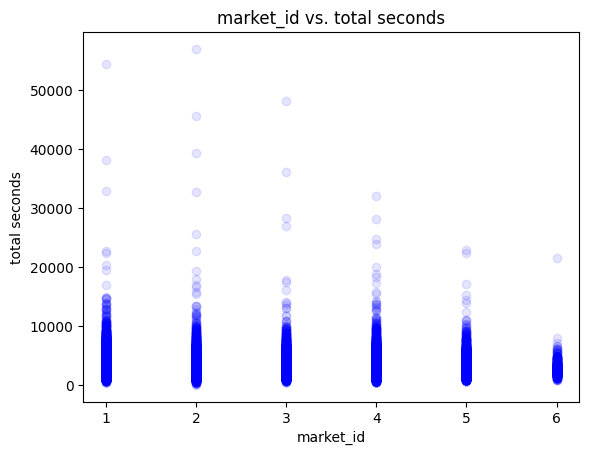

In [67]:
dataA = data_cleaned4[data_cleaned4['total_seconds']<100000]
dataA = dataA[dataA['market_id']<100]

plt.scatter(dataA['market_id'], dataA['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("market_id")
plt.ylabel("total seconds")
plt.title("market_id vs. total seconds")

###estimated_order_place_duration vs. total_seconds###

Text(0.5, 1.0, 'estimated_order_place_duration vs. total seconds')

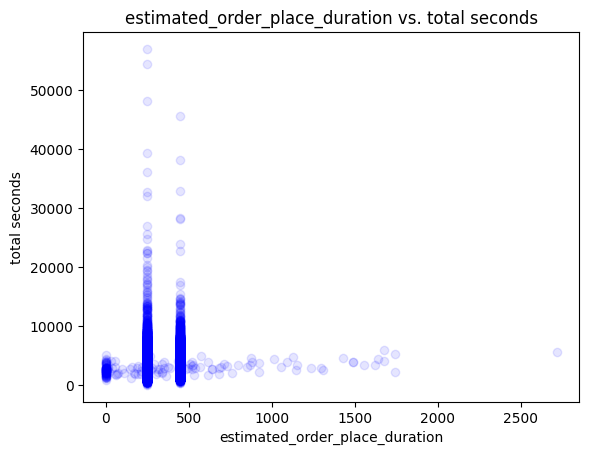

In [ ]:
dataB = data_cleaned4[data_cleaned4['total_seconds']<100000]

plt.scatter(dataB['estimated_order_place_duration'], dataB['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("estimated_order_place_duration")
plt.ylabel("total seconds")
plt.title("estimated_order_place_duration vs. total seconds")

###total_items vs. total_seconds###


(0.0, 100.0)

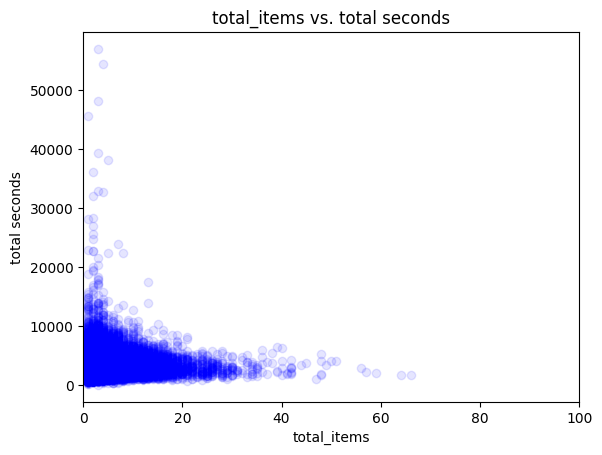

In [ ]:
dataC = data_cleaned4[data_cleaned4['total_seconds']<100000]

plt.scatter(dataC['total_items'], dataB['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("total_items")
plt.ylabel("total seconds")
plt.title("total_items vs. total seconds")
plt.xlim(0,100)

###subtotal vs. total_seconds###


Text(0.5, 1.0, 'subtotal vs. total seconds')

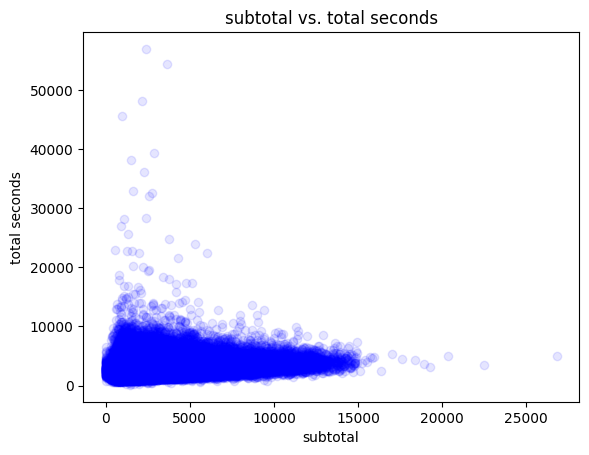

In [ ]:
dataD = data_cleaned4[data_cleaned4['total_seconds']<100000]
plt.scatter(dataD['subtotal'], dataD['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("subtotal")
plt.ylabel("total seconds")
plt.title("subtotal vs. total seconds")

###min_item_price vs. total_seconds###


Text(0.5, 1.0, 'min_item_price vs. total seconds')

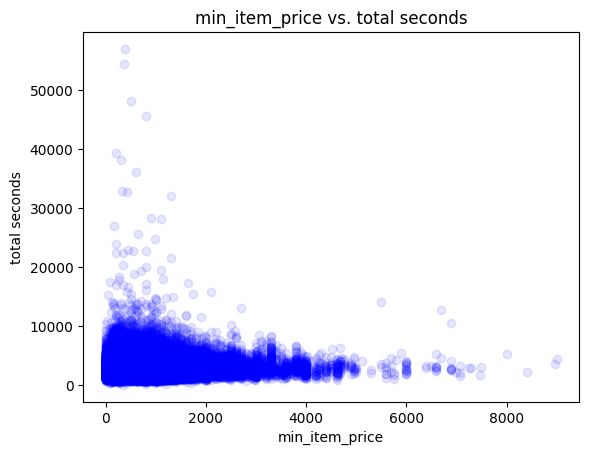

In [ ]:
dataE = data_cleaned4[data_cleaned4['total_seconds']<100000]
dataE = dataE[dataE['min_item_price']<10000]

plt.scatter(dataE['min_item_price'], dataE['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("min_item_price")
plt.ylabel("total seconds")
plt.title("min_item_price vs. total seconds")

###max_item_price vs. total_seconds###


Text(0.5, 1.0, 'max_item_price vs. total seconds')

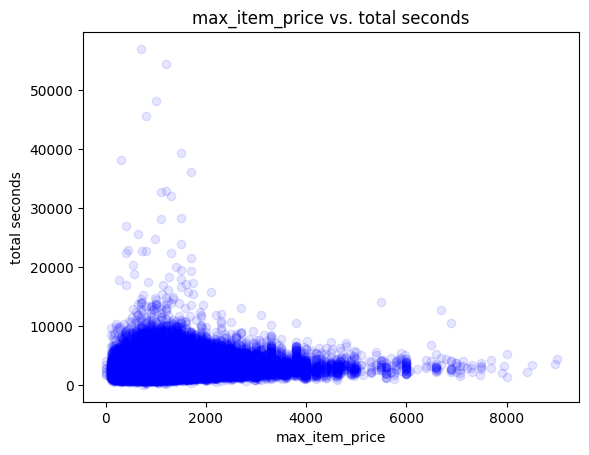

In [ ]:
dataF = data_cleaned4[data_cleaned4['total_seconds']<100000]
dataF = dataF[dataF['max_item_price']<10000]


plt.scatter(dataF['max_item_price'], dataF['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("max_item_price")
plt.ylabel("total seconds")
plt.title("max_item_price vs. total seconds")

###total_outstanding_orders vs. total_seconds###


Text(0.5, 1.0, 'total_outstanding_orders vs. total seconds')

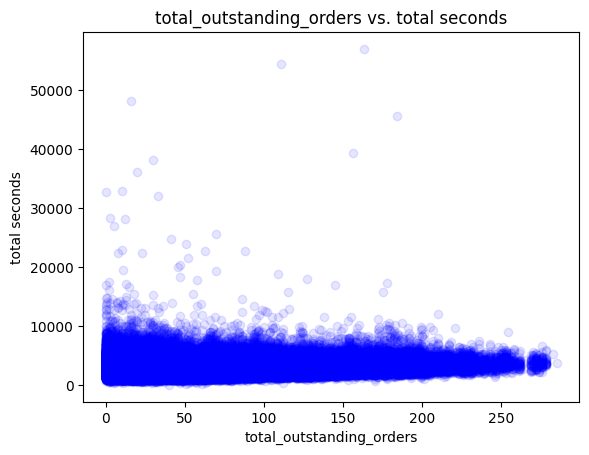

In [ ]:
dataG = data_cleaned4[data_cleaned4['total_seconds']<100000]

plt.scatter(dataG['total_outstanding_orders'], dataG['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("total_outstanding_orders")
plt.ylabel("total seconds")
plt.title("total_outstanding_orders vs. total seconds")

###estimated_store_to_consumer_driving_duration vs. total_seconds###


Text(0.5, 1.0, 'estimated_store_to_consumer_driving_duration vs. total seconds')

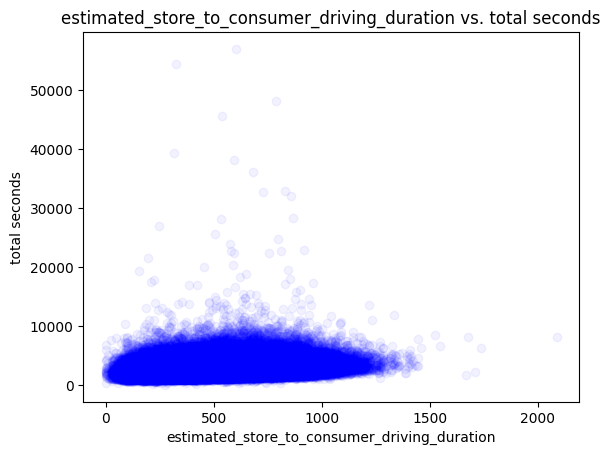

In [ ]:
dataH = data_cleaned4[data_cleaned4['total_seconds']<150000]

plt.scatter(dataH['estimated_store_to_consumer_driving_duration'], dataH['total_seconds'],
            color = 'blue', alpha = 0.05)
plt.xlabel("estimated_store_to_consumer_driving_duration")
plt.ylabel("total seconds")
plt.title("estimated_store_to_consumer_driving_duration vs. total seconds")

###hour_of_day vs. total_seconds###


Text(0.5, 1.0, 'hour_of_day vs. total seconds')

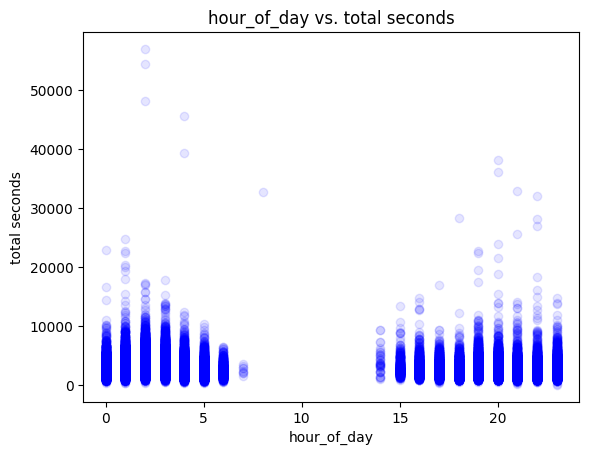

In [ ]:
dataI = data_cleaned4[data_cleaned4['total_seconds']<150000]

plt.scatter(dataI['hour_of_day'], dataI['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("hour_of_day")
plt.ylabel("total seconds")
plt.title("hour_of_day vs. total seconds")

###weekday vs. total_seconds###


(-0.5, 7.0)

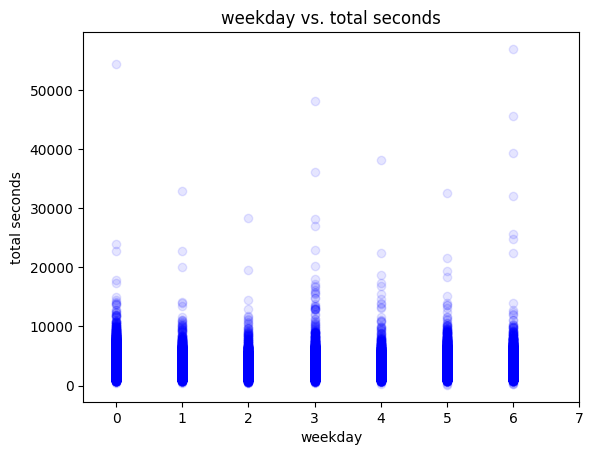

In [ ]:
dataJ = data_cleaned4[data_cleaned4['total_seconds']<150000]

plt.scatter(dataJ['weekday'], dataJ['total_seconds'],
            color = 'blue', alpha = 0.1)
plt.xlabel("weekday")
plt.ylabel("total seconds")
plt.title("weekday vs. total seconds")
plt.xlim(-0.5,7)

##**Removing Outliers**


Based on the scatter plots above, 'total_seconds', 'subtotal', 'estimated_store_to_consumer_driving_duration', 'max_item_price', 'min_item_price' have really large outliers that could negatively impact our models.

We need to remove these outliers using IQR so that the data doesn't negatively impact our model results.

In [68]:
df_temp = data_cleaned4

mask = pd.Series(True, index=df_temp.index)

columns = ['total_seconds','subtotal','estimated_store_to_consumer_driving_duration','max_item_price','min_item_price']
for column in columns:
    Q1 = df_temp[column].quantile(0.25)
    Q3 = df_temp[column].quantile(0.75)
    IQR = Q3 - Q1
    in_range = (df_temp[column] >= Q1 - 1.5 * IQR) & (df_temp[column] <= Q3 + 1.5 * IQR)
    mask &= in_range

data_no_outliers = df_temp[mask]

data_no_outliers.describe()

,market_id,total_items,subtotal,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,hour_of_day,weekday,total_seconds
count,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000,159387.000000
mean,2.762659,3.017009,2365.036942,638.821472,1060.555422,56.964426,307.571094,541.169714,8.812638,3.213844,2706.537647
std,1.329403,2.410665,1290.738836,408.626309,392.362365,52.052454,89.586042,215.951825,8.757512,2.032711,876.984537
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,223.000000
25%,2.000000,2.000000,1350.000000,295.000000,795.000000,17.000000,251.000000,380.000000,2.000000,1.000000,2059.000000
50%,2.000000,3.000000,2085.000000,585.000000,1019.000000,40.000000,251.000000,541.000000,3.000000,3.000000,2586.000000
75%,4.000000,4.000000,3100.000000,900.000000,1299.000000,83.000000,446.000000,697.000000,19.000000,5.000000,3243.000000
max,6.000000,411.000000,6410.000000,1905.000000,2289.000000,278.000000,1740.000000,1179.000000,23.000000,6.000000,5300.000000


##**Graphs After Removing Outliers**

Text(0.5, 1.0, 'total_items vs. total seconds')

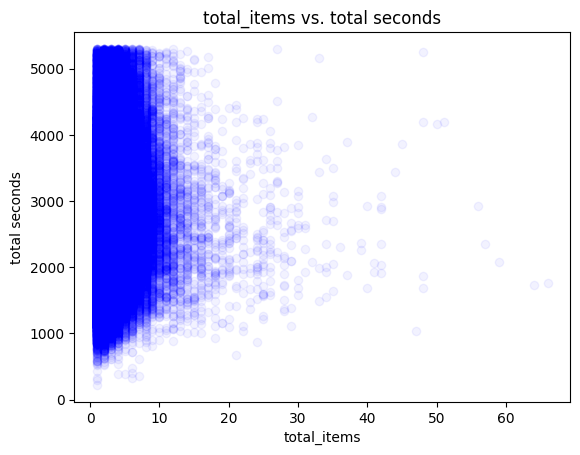

In [ ]:
dataC = data_no_outliers[data_no_outliers['total_seconds']<100000]
dataC = dataC[dataC['total_items']<100]

plt.scatter(dataC['total_items'], dataC['total_seconds'],
            color = 'blue', alpha = 0.05)
plt.xlabel("total_items")
plt.ylabel("total seconds")
plt.title("total_items vs. total seconds")

Text(0.5, 1.0, 'subtotal vs. total seconds')

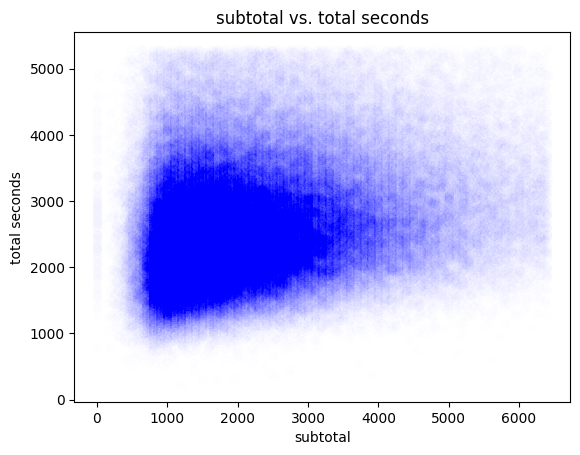

In [ ]:
dataD2 = data_no_outliers[data_no_outliers['total_seconds']<100000]
plt.scatter(dataD2['subtotal'], dataD2['total_seconds'],
            color = 'blue', alpha = 0.002)
plt.xlabel("subtotal")
plt.ylabel("total seconds")
plt.title("subtotal vs. total seconds")

Text(0.5, 1.0, 'min_item_price vs. total seconds')

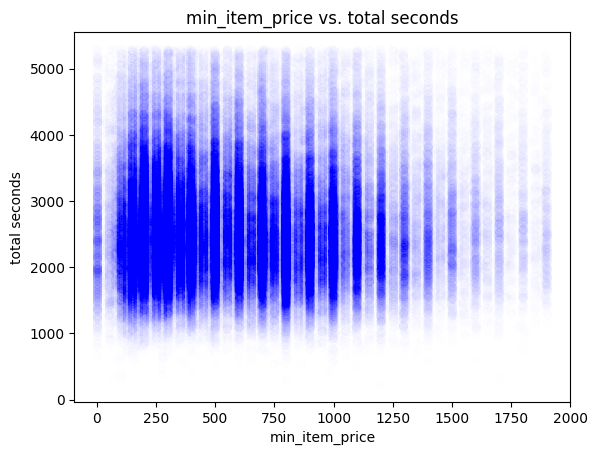

In [ ]:
dataE2 = data_no_outliers[data_no_outliers['total_seconds']<100000]
dataE2 = dataE2[dataE2['min_item_price']<10000]

plt.scatter(dataE2['min_item_price'], dataE2['total_seconds'],
            color = 'blue', alpha = 0.005)
plt.xlabel("min_item_price")
plt.ylabel("total seconds")
plt.title("min_item_price vs. total seconds")

Text(0.5, 1.0, 'max_item_price vs. total seconds')

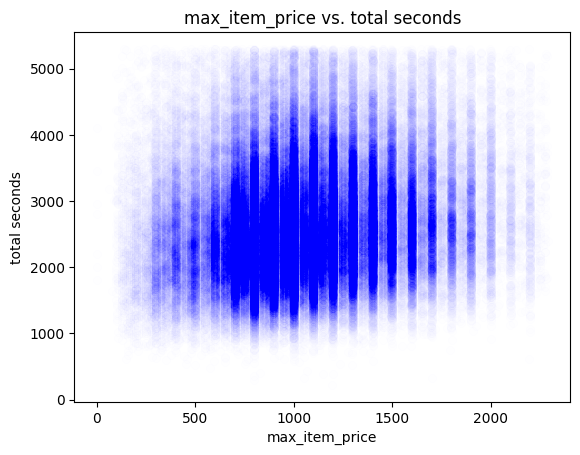

In [ ]:
dataF2 = data_no_outliers[data_no_outliers['total_seconds']<100000]
dataF2 = dataF2[dataF2['max_item_price']<10000]


plt.scatter(dataF2['max_item_price'], dataF2['total_seconds'],
            color = 'blue', alpha = 0.005)
plt.xlabel("max_item_price")
plt.ylabel("total seconds")
plt.title("max_item_price vs. total seconds")

Text(0.5, 1.0, 'estimated_store_to_consumer_driving_duration vs. total seconds')

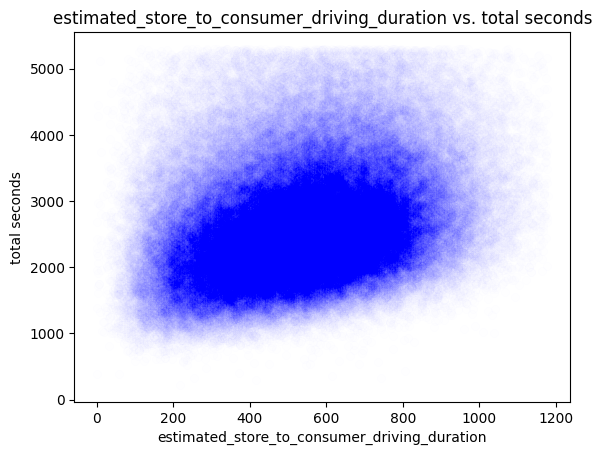

In [ ]:
dataH2 = data_no_outliers[data_no_outliers['total_seconds']<150000]

plt.scatter(dataH2['estimated_store_to_consumer_driving_duration'], dataH2['total_seconds'],
            color = 'blue', alpha = 0.005)
plt.xlabel("estimated_store_to_consumer_driving_duration")
plt.ylabel("total seconds")
plt.title("estimated_store_to_consumer_driving_duration vs. total seconds")

##**Separating Training and Testing Data**

In [69]:
xTrain, xTest, yTrain, yTest = train_test_split(data_no_outliers.drop(['total_seconds'], axis=1),
                                                data_no_outliers['total_seconds'], test_size=0.2, random_state=42)

##**Normalizing Data**

Across the features, the numerical range of data is widely different, making the weights and biases incomparable. In order to normalize all of the columns, use the Standard Scaler function which implements Z-score normalization on the data.

In [70]:
scaler = StandardScaler()
xTrain_scaled = pd.DataFrame(scaler.fit_transform(xTrain), columns =  xTrain.columns)
xTest_scaled = pd.DataFrame(scaler.transform(xTest), columns =  xTest.columns)

yTrain_scaled = pd.Series(scaler.fit_transform(yTrain.values.reshape(-1, 1)).ravel())
yTest_scaled = pd.Series(scaler.transform(yTest.values.reshape(-1, 1)).ravel())

print(type(yTrain_scaled), yTrain_scaled.shape)

<class 'pandas.core.series.Series'> (127509,)


##**Clustering**

Clustering will allow you to see patterns in the data that may not have been evident by simply plotting the data against the response variable through scatter plots.

Plot an elbow graph to identify the best value for K.

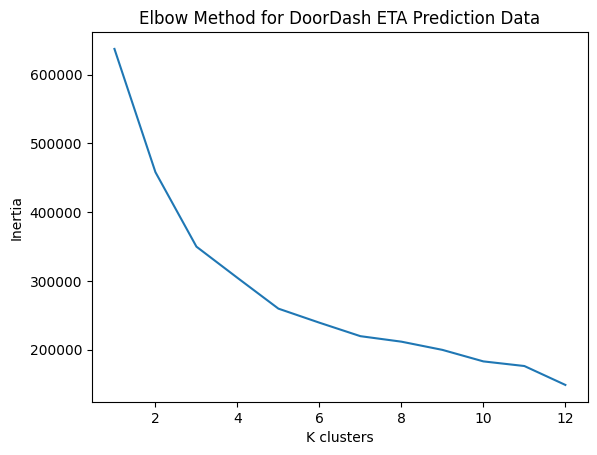

In [71]:
# Select K number of centroids
k_scaler = StandardScaler()
scaled_data = pd.DataFrame(k_scaler.fit_transform(data_no_outliers), columns=data_no_outliers.columns)

X_scaled = scaled_data.copy()[['total_items','subtotal','min_item_price','max_item_price']]

# Elbow method to choose K
inertia = []

for k in range(1,13):
  kmeans = KMeans(n_clusters=k, random_state=42)
  clusters = kmeans.fit_predict(X_scaled)
  X_scaled['cluster'] = clusters
  inertia.append(round(kmeans.inertia_, 1))

plt.plot(range(1,13), inertia)
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for DoorDash ETA Prediction Data')
plt.show()

Based on the graph, the best K value for the K-means algorithm is 4.

In [72]:
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(X_scaled)

cluster_labels = kmeans.labels_
scaled_data['cluster_label'] = cluster_labels

print(scaled_data.groupby('cluster_label'))

scaled_data['cluster_label'] = k_scaler.fit_transform(scaled_data['cluster_label'].values.reshape(-1, 1))
print(scaled_data.groupby('cluster_label').count())

               market_id  total_items  subtotal  min_item_price  \
cluster_label                                                     
-0.732436          96121        96121     96121           96121   
 0.152118          16349        16349     16349           16349   
 1.036672          25123        25123     25123           25123   
 1.921226          21794        21794     21794           21794   

               max_item_price  total_outstanding_orders  \
cluster_label                                             
-0.732436               96121                     96121   
 0.152118               16349                     16349   
 1.036672               25123                     25123   
 1.921226               21794                     21794   

               estimated_order_place_duration  \
cluster_label                                   
-0.732436                               96121   
 0.152118                               16349   
 1.036672                               25123 

###cluster_label vs. total_seconds###

Text(0.5, 1.0, 'cluster_label vs. total seconds')

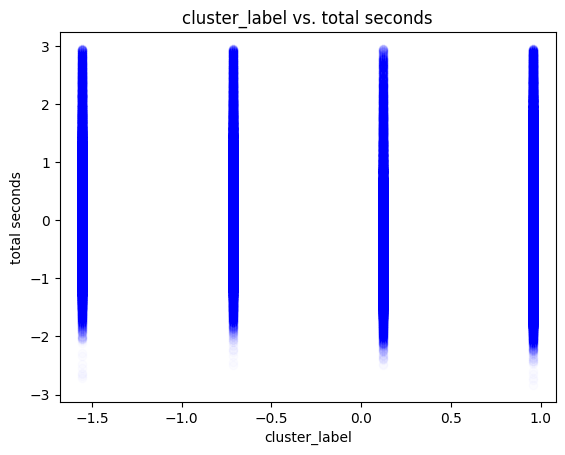

In [ ]:
dataL = scaled_data[scaled_data['total_seconds']<100000]

plt.scatter(dataL['cluster_label'], dataL['total_seconds'],
            color = 'blue', alpha = 0.01)
plt.xlabel("cluster_label")
plt.ylabel("total seconds")
plt.title("cluster_label vs. total seconds")

##**Greedy Algorithm For Linear Regression**

Run the greedy algorithm below to select the top predictors that result in the best model.

In [73]:
#Greedy Algorithm for feature selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linModel = LinearRegression()
best_metric = float('inf')
selectedPredictors = []
modelTemp = []
columns = list(xTrain_scaled.columns)

for i in range(6):
  best_feature_found = None
  for column in columns:
    if column not in selectedPredictors:
      modelTemp = selectedPredictors + [column]
      linModel.fit(xTrain_scaled[modelTemp], yTrain_scaled)
      yPred = linModel.predict(xTest_scaled[modelTemp])
      mse = mean_squared_error(yTest_scaled, yPred)

      if mse < best_metric:
        best_metric = mse
        best_feature_found = column
  if best_feature_found != None:
    selectedPredictors.append(best_feature_found)
  else:
    break

print(selectedPredictors)
xTrain_scaled[selectedPredictors].head()

['estimated_store_to_consumer_driving_duration', 'total_outstanding_orders', 'subtotal', 'estimated_order_place_duration', 'hour_of_day', 'market_id']


,estimated_store_to_consumer_driving_duration,total_outstanding_orders,subtotal,estimated_order_place_duration,hour_of_day,market_id
0,-1.271168,-0.822896,-1.065905,1.538971,0.934452,0.930995
1,2.037277,0.003598,0.248120,-0.633161,-0.778793,-0.573161
2,1.102583,-0.592247,-1.058928,-0.633161,-1.007226,-0.573161
3,-1.201760,-0.669130,0.178348,-0.633161,1.162885,0.178917
4,-1.058317,0.541781,1.619512,-0.633161,1.162885,-0.573161


##**Linear Regression Model + Polynomial Regression Model**

Run the cell below to select the best degree for polynomial regression, the best lambda/alpha value for Ridge regression, and see the metrics for each of the polynomial regressions (of different degrees).

In [ ]:
# Linear Regression + Polynomial Regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor
from numpy.polynomial.polynomial import Polynomial

degrees = [1, 2, 3, 4, 5]
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

for degree in degrees:
  print(f"Degree {degree}")
  # Original Polynomial Regression
  polyreg = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
  polyreg.fit(xTrain_scaled[selectedPredictors], yTrain_scaled)
  y_pred = polyreg.predict(xTest_scaled[selectedPredictors])

  # Original MSE and MAE
  mse = mean_squared_error(yTest_scaled, y_pred)
  mae = mean_absolute_error(yTest_scaled, y_pred)
  print(f"Original mse: {mse}")
  print(f"Original mae: {mae}")

  # Grid search for best alpha
  best_alpha = 1.0
  best_cv_mse = np.inf
  for alpha in alphas:
    polyreg_ridge = make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha=alpha))
    cv_mse = -cross_val_score(polyreg_ridge, xTrain_scaled[selectedPredictors], yTrain_scaled, cv=5, scoring='neg_mean_squared_error').mean()
    if cv_mse < best_cv_mse:
      best_cv_mse = cv_mse
      best_alpha = alpha

  # Polynomial Regression with Ridge Regularization
  polyreg_ridge = make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha=best_alpha))
  polyreg_ridge.fit(xTrain_scaled[selectedPredictors], yTrain_scaled)
  y_pred_ridge = polyreg_ridge.predict(xTest_scaled[selectedPredictors])
  # Ridge MSE and MAE
  mse_ridge = mean_squared_error(yTest_scaled, y_pred_ridge)
  mae_ridge = mean_absolute_error(yTest_scaled, y_pred_ridge)
  print(f"Ridge mse: {mse_ridge}")
  print(f"Ridge mae: {mae_ridge}")
  # Cross-Validated MSE and MAE
  cv_scores_mse = cross_val_score(polyreg_ridge, xTrain_scaled[selectedPredictors], yTrain_scaled, cv=5, scoring='neg_mean_squared_error')
  cv_mse = -cv_scores_mse.mean()
  cv_scores_mae = cross_val_score(polyreg_ridge, xTrain_scaled[selectedPredictors], yTrain_scaled, cv=5, scoring='neg_mean_absolute_error')
  cv_mae = -cv_scores_mae.mean()
  print(f"cv mse: {cv_mse}")
  print(f"cv mae: {cv_mae}")

##**Decision Tree Model**

The cell below runs multiple loops to find the optimal max_depth and min_samples_leaf for the decision tree model

In [ ]:
decTreeMSEs = []
decTreeValuesTested = []

for i in range(10, 21):
  for j in range(100, 501, 100):
    decTreeIter = DecisionTreeRegressor(max_depth = i, min_samples_leaf = j, random_state = 0)
    decTreeIter.fit(xTrain_scaled, yTrain_scaled)
    decTreeIterPreds = decTreeIter.predict(xTest_scaled)
    decTreeIterMSE = mean_squared_error(yTest_scaled, decTreeIterPreds)
    decTreeValuesTested += [(i, j)]
    decTreeMSEs += [decTreeIterMSE]

decTreeMinMSE = min(decTreeMSEs)
decTreeMinMSEIndex = decTreeMSEs.index(decTreeMinMSE)
print(decTreeMinMSE, decTreeValuesTested[decTreeMinMSEIndex])

After running the model, we can see that the optimal max_depth is 15 and the min_samples_leaf is 200. Using these hyperparameters, we yield an mse of 0.8007229225962674.

Now run a k-fold algorithm to find the cv score for this decision tree model.

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

decisionTree = DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 200, random_state=0)

decisionTree.fit(xTrain_scaled, yTrain_scaled)
predsDT = decisionTree.predict(xTest_scaled)

kfoldDT = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
cvScoreDT = model_selection.cross_val_score(decisionTree, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_squared_error', cv=kfold)
cvMaeDT = model_selection.cross_val_score(decisionTree, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_absolute_error', cv=kfold)

In [ ]:
print(f"MSE for Decision Tree: {(-1 * cvScoreDT).mean()}")
print(f"MAE for Decision Tree: {(-1 * cvMaeDT).mean()}")

MSE for Decision Tree: 0.7959110316323239
MAE for Decision Tree: 0.7070023374030607


##**Random Forest Regression Model**

The cell below tries fitting the data using a Random Forest Regression Model.

In [ ]:
# Random Forest

randomForest = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 50, random_state = 0)
randomForest.fit(xTrain_scaled, yTrain_scaled)
randomForestPred = randomForest.predict(xTest_scaled)
randomForestScore = mean_squared_error(yTest_scaled, randomForestPred)

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
cvScoreRF = model_selection.cross_val_score(randomForest, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_squared_error', cv=kfold)
cvMaeRF = model_selection.cross_val_score(randomForest, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_absolute_error', cv=kfold)

In [ ]:
print(f"MSE for Random Forest: {(-1 * cvScoreRF).mean()}")
print(f"MAE for Random Forest: {(-1 * cvMaeRF).mean()}")

MSE for Random Forest: 0.7645830826463217
MAE for Random Forest: 0.6929210387572369


##**Neural Network Model**

Run the cell below to find the optimal lambda/alpha for L2 regularization. You will see that 0.1 yields the lowest MSE.

In [76]:
from sklearn.neural_network import MLPRegressor
lambdaList = [0.001, 0.01, 0.1, 1, 5, 10, 20, 100, 1000]

for l in lambdaList:
  NNmodel = MLPRegressor(hidden_layer_sizes=(64,32,16), activation='relu',
                         alpha=l, solver="adam", max_iter=200, random_state=42)

  NNmodel.fit(xTrain_scaled, yTrain_scaled)
  y_pred = NNmodel.predict(xTest_scaled)
  mse = mean_squared_error(yTest_scaled, y_pred)
  print(mse)

0.7555421875751395
0.745209679982672
0.749605055882063
0.8013635315322923
0.8316754300481609
0.8416023234924026
0.8970802038477983
0.9896966936187183
0.9896978446110412


In [ ]:
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
NNmodel = MLPRegressor(hidden_layer_sizes=(64,32,16), activation='relu',
                       alpha=0.01, solver="adam", max_iter=500, random_state=42)

cvScoreNNmse = model_selection.cross_val_score(NNmodel, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_squared_error', cv=kfold)
cvScoreNNmae = model_selection.cross_val_score(NNmodel, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_absolute_error', cv=kfold)

print(f"CV Score (MSE): {-1 * cvScoreNNmse}")
print(f"CV Score (MAE): {-1 * cvScoreNNmae}")
print("")

In [78]:
print(f"CV-score (MSE) for Neural Network: {(-1 * cvScoreNNmse).mean()}")
print(f"CV-score (MAE) for Neural Network: {(-1 * cvScoreNNmae).mean()}")

CV-score (MSE) for Neural Network: 0.7917236554181726
CV-score (MAE) for Neural Network: 0.6851167050279487


In [58]:
from sklearn.neural_network import MLPRegressor

NNmodel = MLPRegressor(hidden_layer_sizes=(64,32,16), activation='relu',
                        alpha=0.1, solver="adam", max_iter=200, random_state=42)

NNmodel.fit(xTrain_scaled, yTrain_scaled)
y_pred = NNmodel.predict(xTest_scaled)

In [59]:
original_yTest = scaler.inverse_transform(yTest_scaled.values.reshape(-1, 1))
original_yPred = scaler.inverse_transform(y_pred.reshape(-1, 1))

Text(0.5, 1.0, 'y Test vs. y Test Prediction')

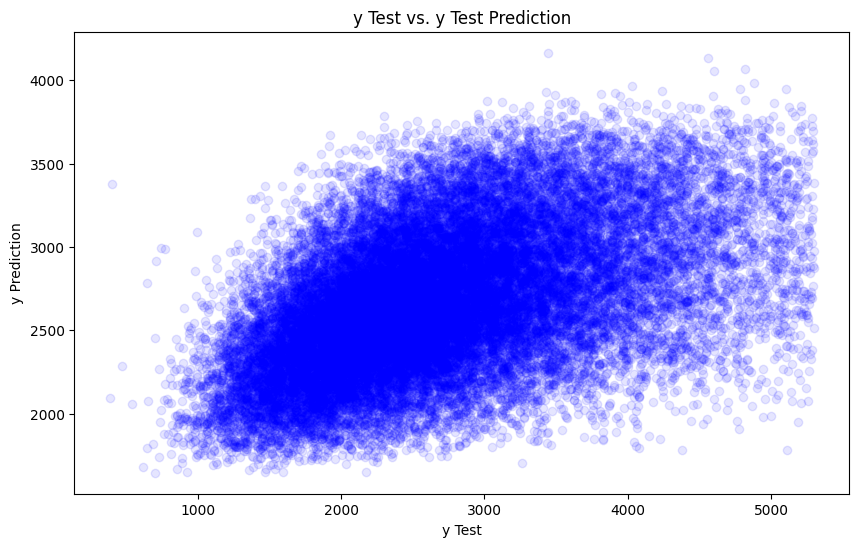

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(original_yTest, original_yPred, color = 'blue', alpha = 0.1)
plt.xlabel("y Test")
plt.ylabel("y Prediction")
plt.title("y Test vs. y Test Prediction")

##**Logistic Regression Model**
(Does not work for our dataset because our data is not categorical)

In [ ]:
# Logistic Regression

# ##I don't think this can be used because our output is not categorical
# from sklearn.model_selection import KFold
# from sklearn.linear_model import LogisticRegression

# logRegModel = LogisticRegression()
# logRegModel.fit(xTrain[selectedPredictors], yTrain)
# logRegPred = logRegModel.predict(xTest)
# logRegKFold = KFold(n_splits = 10, random_state = 5, shuffle = True)
# logRegKFoldScore = model_selection.cross_val_score(logRegModel, xTrain[selectedPredictors], yTrain, cv = 5)
# print(f"Logistic Regression mean kfold score: {logRegKFoldScore.mean()}")

Gradient Boost yielded similar results to Random Forest Regression, so we did not use it.

In [ ]:
# # Gradient Boosting

# gradientBoost = GradientBoostingRegressor(criterion = 'squared_error', min_samples_leaf = 50, random_state = 0)
# gradientBoost.fit(xTrain_scaled, yTrain_scaled)
# gradientBoostPred = gradientBoost.predict(xTest_scaled)
# gradientBoostScore = mean_squared_error(yTest_scaled, gradientBoostPred)
# print(gradientBoostScore)

# kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
# cvScore = model_selection.cross_val_score(gradientBoost, xTrain_scaled, yTrain_scaled, scoring = 'neg_mean_squared_error', cv=kfold)
# print(-1 * cvScore)
# print(cvScore.mean())